# Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv





#Imports

In [ ]:
import numpy as np
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.datasets import make_classification


from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

from xgboost import XGBClassifier
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from google.colab import drive

###Завантаження та ознайомлення з набором даних

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_to = '/content/drive/MyDrive/Python/ML/DATA/tweet_sentiment_train.csv.zip'

In [ ]:
df = pd.read_csv(path_to)

In [ ]:
#структура
df.shape

(27481, 4)

In [ ]:
df.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
#основна статистика
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [ ]:
#видалення записів з пропущеними значеннями
df = df.dropna()

### Exploratory Data Analysis

- Проведено аналіз кількості класів та розподілу міток.
- Візуалізовано розподіл довжин текстів в символах.

In [ ]:
#аналіз розподілу класів
df.sentiment.value_counts(normalize=True)

,proportion
sentiment,
neutral,0.404549
positive,0.312300
negative,0.283151


Співвідношення класів 40/31/28. З огляду на те, що немає великого дисбалансу класів, методи нормалізації класів не планую застосовувати.

<ipython-input-10-7a114459662a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_post'] = df['text'].apply(len)


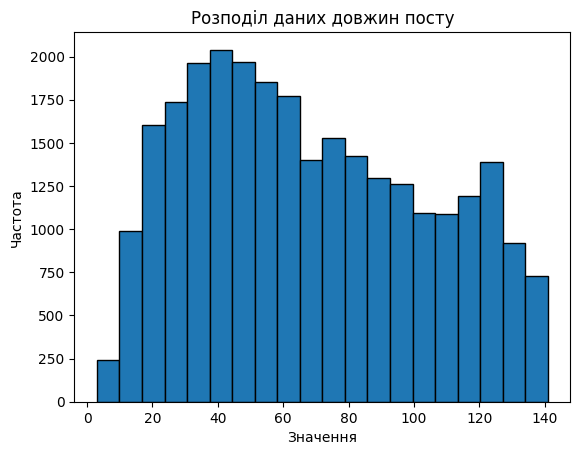

In [ ]:
#Аналіз розподілу довжини постів

df['len_post'] = df['text'].apply(len)
# Побудова гістограми
plt.hist(df['len_post'], bins=20, edgecolor='black')
plt.title('Розподіл даних довжин посту')
plt.xlabel('Значення')
plt.ylabel('Частота')

plt.show()

**Висновки:**
Від 1500 до 2000 разів зустрічаються пости від 20 до 70 символів.

### Попередня обробка текстових даних та векторизація з bag of words


Отримуємо вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.





Підготовка до попередньої обробки текстів

In [ ]:
def tokenize(text):
    return [stemmer.stem(word) for word in word_tokenize(text)]

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
english_stopwords = stopwords.words('english')

In [ ]:
stemmer = SnowballStemmer(language='english')

Векторізація

In [ ]:
vectorizer = CountVectorizer(lowercase=True,
                             tokenizer=tokenize,
                             stop_words=english_stopwords,
                             max_features=1000)

In [ ]:
vectorizer.fit(df.text)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


CountVectorizer(max_features=1000,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function tokenize at 0x797f27931480>)

In [ ]:
inputs = vectorizer.transform(df.text)

### Побудова класифікатора



In [ ]:
 #поділ на тренувавльнй та тестовий набори
 X_train_bow, X_test_bow, y_train, y_test = train_test_split(inputs, df.sentiment, test_size=0.3, random_state=42)

#####Логістична регресія
Оскільки у нас багатокласова класифікація застосовую класифікатор OneVsOneClassifier та OneVsRestClassifier для порівняння ефективності моделі.

**OneVsOneClassifier**

In [ ]:
MAX_ITER = 3000

In [ ]:
# Логістична регресія зі стратегією one-vs-one (OvO)
log_reg = LogisticRegression(max_iter=MAX_ITER, solver='saga')

ovo_model = OneVsOneClassifier(log_reg)
ovo_model.fit(X_train_bow, y_train)


OneVsOneClassifier(estimator=LogisticRegression(max_iter=3000, solver='saga'))

In [ ]:
#Оцінка моделі на тренувальних даних
ovo_train_pred = ovo_model.predict(X_train_bow)

# Обчислимо метрики precision та recall для кожного класу
print(classification_report(y_train, ovo_train_pred))

              precision    recall  f1-score   support

    negative       0.78      0.65      0.71      5425
     neutral       0.68      0.80      0.74      7774
    positive       0.81      0.74      0.77      6037

    accuracy                           0.74     19236
   macro avg       0.76      0.73      0.74     19236
weighted avg       0.75      0.74      0.74     19236



In [ ]:
#Оцінка моделі на тестових даних
ovo_test_pred = ovo_model.predict(X_test_bow)

# Обчислимо метрики precision та recall для кожного класу
print(classification_report(y_test, ovo_test_pred))

              precision    recall  f1-score   support

    negative       0.73      0.58      0.64      2356
     neutral       0.63      0.76      0.69      3343
    positive       0.76      0.72      0.74      2545

    accuracy                           0.69      8244
   macro avg       0.71      0.68      0.69      8244
weighted avg       0.70      0.69      0.69      8244



 **OneVsRestClassifier**

In [ ]:
ovr_model = OneVsRestClassifier(log_reg)
ovr_model.fit(X_train_bow, y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=3000, solver='saga'))

In [ ]:
ovr_train_pred = ovr_model.predict(X_train_bow)

# Обчислимо метрики precision та recall для кожного класу
print(classification_report(y_train, ovr_train_pred))

              precision    recall  f1-score   support

    negative       0.77      0.65      0.71      5425
     neutral       0.68      0.78      0.73      7774
    positive       0.79      0.75      0.77      6037

    accuracy                           0.74     19236
   macro avg       0.75      0.73      0.74     19236
weighted avg       0.74      0.74      0.74     19236



In [ ]:
ovr_test_pred = ovr_model.predict(X_test_bow)

# Обчислимо метрики precision та recall для кожного класу
print(classification_report(y_test, ovr_test_pred))

              precision    recall  f1-score   support

    negative       0.72      0.58      0.64      2356
     neutral       0.64      0.74      0.69      3343
    positive       0.75      0.73      0.74      2545

    accuracy                           0.69      8244
   macro avg       0.70      0.68      0.69      8244
weighted avg       0.70      0.69      0.69      8244



Обидва класифікатора дають аналогічні результати. Для подальшого вибору буду брати OVR класифікатор.

#####Дерево рішень

In [ ]:
model_tree = DecisionTreeClassifier(random_state=42)
model_tree.fit(X_train_bow, y_train)
tree_train_predict = model_tree.predict(X_train_bow)

# Обчислимо метрики precision та recall для кожного класу
print(classification_report(y_train, tree_train_predict))

              precision    recall  f1-score   support

    negative       0.99      0.99      0.99      5425
     neutral       0.98      0.99      0.99      7774
    positive       1.00      0.99      0.99      6037

    accuracy                           0.99     19236
   macro avg       0.99      0.99      0.99     19236
weighted avg       0.99      0.99      0.99     19236



In [ ]:
tree_test_predict = model_tree.predict(X_test_bow)

# Обчислимо метрики precision та recall для кожного класу
print(classification_report(y_test, tree_test_predict))

              precision    recall  f1-score   support

    negative       0.56      0.59      0.57      2356
     neutral       0.61      0.58      0.60      3343
    positive       0.66      0.68      0.67      2545

    accuracy                           0.61      8244
   macro avg       0.61      0.62      0.61      8244
weighted avg       0.61      0.61      0.61      8244



#####Бустинг

In [ ]:

from sklearn.preprocessing import LabelEncoder

# Енкодинг міток
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

#Тренування моделі
xgb_clf = XGBClassifier(
    max_depth=3,
    n_estimators=10,
    enable_categorical=True,  # для категорійних ознак
    use_label_encoder=False,  # щоб уникнути попереджень, якщо використовуєте нові версії XGBoost
    missing=np.nan,  # явне вказування пропущених значень
    device='cuda'
)

xgb_clf.fit(X_train_bow, y_train_encoded)
xgb_predict = xgb_clf.predict(X_test_bow)

# Перетворюємо числові передбачення назад у текстові мітки
xgb_predict_labels = label_encoder.inverse_transform(xgb_predict)

# Обчислимо метрики precision та recall для кожного класу
print(classification_report(y_test, xgb_predict_labels))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:00:00] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:00:00] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:00:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

    negative       0.79      0.30      0.44      2356
     neutral       0.52      0.87      0.65      3343
    positive       0.76      0.54      0.63      2545

    accuracy                           0.60      8244
   macro avg       0.69      0.57      0.57      8244
weighted avg       0.67      0.60      0.58      8244



**Висновки:** Найкращу якість показала логістична регресія.

### Аналіз впливовості слів в отриманого класифікатора


In [ ]:
# Отримуємо список токенів (слів)
feature_names = vectorizer.get_feature_names_out()

# Для кожної пари класів у One-vs-One класифікаторі
for i, estimator in enumerate(ovr_model.estimators_):
    print(f"Коефіцієнти для класифікації класів {ovr_model.classes_[i]}:")

    # Коефіцієнти моделі
    coefficients = estimator.coef_.flatten()

    # Створимо DataFrame з токенами і їхніми вагами
    importance_df = pd.DataFrame({'word': feature_names, 'coefficient': coefficients})

    # Відсортуємо за найбільш важливими словами
    importance_df = importance_df.sort_values(by='coefficient', ascending=False)

    print(importance_df.head(10))  # Найбільш впливові слова
    print(importance_df.tail(10))  # Найменш впливові слова (або ті, що впливають негативно)


Коефіцієнти для класифікації класів negative:
        word  coefficient
741      sad     2.763745
831     suck     2.749891
152     bore     2.567779
327     fail     2.531748
807    sorri     2.388569
427  headach     2.366183
830   stupid     2.364205
778     sick     2.360587
974    worst     2.355076
586     miss     2.329318
       word  coefficient
616    nice    -1.800602
404   great    -1.903860
950  welcom    -1.970712
302   enjoy    -2.014979
244    cute    -2.146205
79     amaz    -2.150606
390    glad    -2.314887
547    love    -2.446340
859   thank    -2.664074
107  awesom    -3.085886
Коефіцієнти для класифікації класів neutral:
         word  coefficient
965  wolverin     1.037682
103     avail     0.984974
881     tonit     0.973650
482       ive     0.971246
316    except     0.871928
470    includ     0.842640
764     shall     0.804343
759      sent     0.802623
24         11     0.783901
57        add     0.774240
          word  coefficient
79        amaz    -1.54

**Висновки:** досить нелогічно інтерпретувати як негативний настрій використання слів: 'вітаю', 'перемога', 'приголомшливий'. Можливо це і призводить до великої ількості інтерпритації нейтральних висказувань як негативних.

###  Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.


Векторизація

In [ ]:
#Задаємо параметри попередньої підготовки текстів та векторизації
vectorizer_tf = TfidfVectorizer(lowercase=True,
                             tokenizer=tokenize,
                             stop_words=english_stopwords,
                             max_features=1000)



In [ ]:
#векторізуємо текстові дані застосувавши TF-IDF
vectorizer_tf.fit(df.text)
inputs_tf = vectorizer_tf.transform(df.text)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


In [ ]:
# Створюємо масив індексів
indices = np.arange(inputs_tf.shape[0])

In [ ]:
#поділ на тренувавльнй та тестовий набори та отримуємо індекси
X_train_tf, X_test_tf, y_train_tf, y_test_tf, train_indices, test_indices = train_test_split(
    inputs_tf,
    df.sentiment,
    indices,
    test_size=0.3,
    random_state=42
)

In [ ]:
MAX_ITER = 3000

# Логістична регресія зі стратегією one-vs-rest (OvR)
log_reg = LogisticRegression(max_iter=MAX_ITER, solver='sag')
ovr_model_tf = OneVsRestClassifier(log_reg)
ovr_model_tf.fit(X_train_tf, y_train_tf)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=3000, solver='sag'))

In [ ]:
ovr_train_pred_tf = ovr_model_tf.predict(X_train_tf)

# Обчислимо метрики precision та recall для кожного класу
print(classification_report(y_train_tf, ovr_train_pred_tf))

              precision    recall  f1-score   support

    negative       0.77      0.64      0.70      5425
     neutral       0.67      0.78      0.72      7774
    positive       0.79      0.73      0.76      6037

    accuracy                           0.73     19236
   macro avg       0.74      0.72      0.73     19236
weighted avg       0.73      0.73      0.73     19236



In [ ]:
ovr_test_pred_tf = ovr_model_tf.predict(X_test_tf)

# Обчислимо метрики precision та recall для кожного класу
print(classification_report(y_test_tf, ovr_test_pred_tf))

              precision    recall  f1-score   support

    negative       0.72      0.57      0.63      2356
     neutral       0.64      0.75      0.69      3343
    positive       0.76      0.72      0.74      2545

    accuracy                           0.69      8244
   macro avg       0.71      0.68      0.69      8244
weighted avg       0.70      0.69      0.69      8244



In [ ]:
# Отримуємо список токенів (слів)
feature_names = vectorizer_tf.get_feature_names_out()

# Для кожної пари класів у One-vs-Rest класифікаторі
for i, estimator in enumerate(ovr_model_tf.estimators_):
    print(f"Коефіцієнти для класифікації класів {ovr_model_tf.classes_[i]}:")

    # Коефіцієнти моделі
    coefficients = estimator.coef_.flatten()

    # Створимо DataFrame з токенами і їхніми вагами
    importance_df = pd.DataFrame({'word': feature_names, 'coefficient': coefficients})

    # Відсортуємо за найбільш важливими словами
    importance_df = importance_df.sort_values(by='coefficient', ascending=False)

    print(importance_df.head(10))  # Найбільш впливові слова
    print(importance_df.tail(10))  # Найменш впливові слова (або ті, що впливають негативно)

Коефіцієнти для класифікації класів negative:
       word  coefficient
741     sad     6.414864
586    miss     6.004142
831    suck     5.541060
424    hate     5.235992
807   sorri     5.234849
152    bore     4.730526
327    fail     4.564962
778    sick     4.448840
459    hurt     4.316874
830  stupid     4.261028
       word  coefficient
244    cute    -2.834507
79     amaz    -2.862321
302   enjoy    -2.923579
390    glad    -2.973183
616    nice    -3.199679
404   great    -3.563684
446    hope    -3.740530
107  awesom    -4.525767
859   thank    -5.289749
547    love    -5.695556
Коефіцієнти для класифікації класів neutral:
         word  coefficient
45          ?     1.283005
316    except     1.168563
965  wolverin     1.146841
863    though     1.122411
194     check     1.084377
819      stay     1.076428
538       lol     1.068967
862       tho     1.056364
731     revis     1.024305
759      sent     1.016400
       word  coefficient
424    hate    -3.194059
831    suck 

### Аналіз помилок класифікації з векторизацією TF-IDF.


In [ ]:
#формуємо датафрейм для аналізу помилок на базі тренувального набору даних
results_df = pd.DataFrame({
    'text': df.text.iloc[train_indices].values,  # Текст з оригінального датафрейму
    'actual': y_train_tf,  # Задані мітки
    'predicted': ovr_train_pred_tf,  # Прогнози
})


In [ ]:
#обираємо записи з помилковими результатами
df_error = results_df[results_df.actual != results_df['predicted']]

In [ ]:
# Обчислимо метрики precision та recall для кожного класу
print(classification_report(y_train_tf, ovr_train_pred_tf))

              precision    recall  f1-score   support

    negative       0.77      0.64      0.70      5425
     neutral       0.67      0.78      0.72      7774
    positive       0.79      0.73      0.76      6037

    accuracy                           0.73     19236
   macro avg       0.74      0.72      0.73     19236
weighted avg       0.73      0.73      0.73     19236



In [ ]:
confusion_matrix(results_df.actual, results_df['predicted'], normalize='true').round(2)

array([[0.64, 0.3 , 0.06],
       [0.11, 0.78, 0.11],
       [0.04, 0.23, 0.73]])

In [ ]:
#30% випадків - які насправді є класом 'neutral', але були класифіковані як 'negative'
df_error[(df_error['actual']== 'neutral')&(df_error['predicted']== 'negative')]

,text,actual,predicted
22394,just checked again and it worked!! Sorry,neutral,negative
22385,Fish fingers and potato croquettes it is then!...,neutral,negative
922,"Dadgum, I think this nations shipping needs ha...",neutral,negative
581,no bueno. hollykins needs to feel better asa...,neutral,negative
26561,"Ive been up since 530,i hate wen i cant sleep....",neutral,negative
...,...,...,...
11364,"*Hand up* Me, I`m going #localgovcamp",neutral,negative
4427,"Finally feels like a nice summer day, and I`m ...",neutral,negative
6266,_McFlyy FINALY MY CHANCE HAS CAME. . TO KILL Y...,neutral,negative
22119,wishes she would call him ... *hc*,neutral,negative


In [ ]:
#22% випадків - кількість зразків класу 'positive', які були неправильно класифіковані як 'neutral'
df_error[(df_error['actual']== 'positive')&(df_error['predicted']== 'neutral')]

,text,actual,predicted
18014,that is definitely a blast from the past,positive,neutral
27154,lmao i get that alot haha,positive,neutral
26150,baaha & healthy choice my friend! (:,positive,neutral
3532,have a glass of cold water and meditate a bi...,positive,neutral
12365,I nvr wanted May to come to an end,positive,neutral
...,...,...,...
996,my sleep pattern is screwed i need to try and...,positive,neutral
8434,I like that term 'today list' - better than '...,positive,neutral
26383,there`s nothing wrong with having a quiet day...,positive,neutral
2434,make sure you practice your hooping today!,positive,neutral


##Шляхи вдосконалення


1. Задача моделі визначати настрій тексту. В текстах багато використовується знаків пунктуації (знаки оклику та багато крапок) та смайлів, що передають емоцію:
  - не викючати знаки оклику з фраз;
  - знайти бібоіотеку з обробки смайлів і застосувати.
2. Емоцію в текстах також передають словами написаними CapsLock. Спробувати не змінювати регістр слів, якщо великі всі літери в слові.
3. Емоцію передають в текстах також за рахунок гіперболізованого подовження голосних в словах. Спробувати якщо більше 3х однакових голосних підряд в слові - обробляти по іншому.